In [1]:
import json, yt
import matplotlib.pyplot as plt
import numpy as np

/home/darksky/anaconda3/envs/deepai/lib/python3.9/site-packages/yt/utilities/logger.py:4: VisibleDeprecationWarning: The configuration file /home/darksky/.config/yt/ytrc is deprecated in favor of /home/darksky/.config/yt/yt.toml. Currently, both are present. Please manually remove the deprecated one to silence this warning.
Deprecated since v4.0.0. This feature will be removed in v4.1.0
  from yt.config import ytcfg


/home/darksky/anaconda3/envs/deepai/lib/python3.9/site-packages/yt/sample_data/api.py:138: UserWarning: Storage directory from yt config doesn't exist (currently set to '/does/not/exist'). Current working directory will be used instead.
  warn(


FileNotFoundError: No such file or directory: 'C:/Users/azton/Projects/phoenix/phx256-1/RD1250/RD1250'.

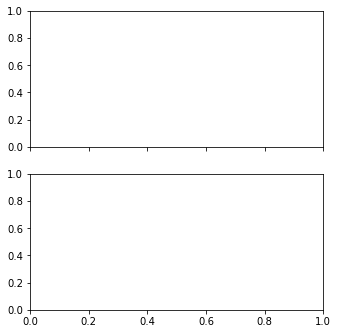

In [2]:
fig, ax = plt.subplots(2,1, figsize=(5.25,5.5), sharex=True)
ds = yt.load('/home/darksky/Projects/enzo_sim/phoenix/phx256-1/RD1250/RD1250')
sims = ['phx256-1','phx256-2', 'phx512']
outs = [1250, 1100, 985]
colors = ['tab:blue','tab:green', 'tab:orange'] #distinguish sims
linestyles = ['-','-.'] #for p2-p3
st_types = ['p2', 'p3']
type_lab = ['PII','PIII']
min_time = 1e20
max_time = 0
for i, sim in enumerate(sims):
    for j, star in enumerate(st_types):
        starfile = '/home/darksky/Projects/phoenix_analysis/%s/RD%04d_%s_starfile.json'%(sim, outs[i], star)
        with open(starfile, 'r') as f:
            stardict = json.load(f)
        tend = float(max(stardict['birth']))
        tstart = float(min(stardict['birth']))
        if tend > max_time: max_time = tend
        if tstart < min_time: min_time = tstart
tbins = np.linspace(min_time, max_time, 100)
zbins = ds.cosmology.z_from_t(ds.arr(tbins, 'Myr'))
for i, sim in enumerate(sims):
    for j, star in enumerate(st_types):
        starfile = '/home/darksky/Projects/phoenix_analysis/%s/RD%04d_%s_starfile.json'%(sim, outs[i], star)
        box_size = 1.765 ** 3 if '256' in sim else 3.53 ** 3
        box_size /= 0.6766 ** 3 # Mpc instead of h^-1
        with open(starfile, 'r') as f:
            stardict = json.load(f)    
        dt = (tbins[1] - tbins[0])*1e6 #yr
        mbins = np.zeros(101)
        nbins = np.zeros(101)
        for ii, t in enumerate(stardict['birth']):
            if stardict['mass'][ii] <= 300:
                tbin = np.digitize(t, tbins)
                mbins[tbin] += stardict['mass'][ii]
                nbins[tbin] += 1
        print(np.unique(mbins))
        cnum = np.array([nbins[:ii].sum() for ii in range(len(nbins))])
        cmass = np.array([mbins[:ii].sum() if mbins[ii] > 0 else 0 for ii in range(len(mbins))])
        
        dmdt = np.array([(cmass[ii] - cmass[ii-1])/dt if cmass[ii-1] > 0 else 0 for ii in range(1,len(cmass))]) \
                        / box_size
        
        tdmdt = tbins.max() - tbins # alter to lookback time

        h0 = ax[0].plot(zbins, dmdt, color=colors[i], linestyle = linestyles[j], linewidth=2, alpha=0.7, label='%s: %s'%(sim, type_lab[j]))
        h1 = ax[1].plot(zbins[cmass[1:] != 0], cmass[cmass != 0]/ box_size, 
                       color=colors[i], linestyle = linestyles[j], linewidth=2, alpha=0.7, label='%s: %s'%(sim, type_lab[j]))
timeticks = ['%0.1f'%ds.cosmology.t_from_z(z).to('Myr') for z in np.arange(26, 13, -2)]
ax[0].set_yscale('log')
ax[1].set_yscale('log')
ax[0].set_ylim(2e-7, 5e-4)
ax[0].set_xlim(12, 28)
ax[1].set_xlabel('Redshift')
ax[0].set_ylabel('SFRD [M$_\odot$ yr$^{-1}$ Mpc$^{-3}$]')
ax[1].set_ylabel('M$_*$ [M$_\odot$ Mpc$^{-3}$]')
ax[0].legend(ncol=3, frameon=False, loc='upper right', bbox_to_anchor=(1.1,1.25))
plt.subplots_adjust(hspace=0.05)
plt.savefig('%s/P3-P2_SFR_combined.pdf'%('images'), bbox_inches='tight')

In [29]:
ds.cosmology.z_from_t(ds.quan(138.9, 'Myr'))

23.913890794295174

In [1]:
import yt
ds = yt.load("phoenix")


NameError: name 'star' is not defined